In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import scipy.constants as sp
import random
from sklearn.linear_model import LinearRegression
import itertools
from scipy.integrate import quad
from scipy.optimize import root_scalar
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost
import joblib
from sklearn.feature_selection import SelectFromModel

In [2]:
# open results xr
results = xr.open_dataset("results.h5", engine = "netcdf4")

In [3]:
# recreate coordinates for plotting

tree_depth = np.array([6, 10])
num_trees = np.array([10, 100])
L1_reg = np.array([0, 5, 10, 20])

t_list = []
n_list = []
l_list = []

coords = []
for t in tree_depth:
    for n in num_trees:
        for l in L1_reg:
            params = (n, t, l)
            coords.append(params)
            t_list.append(t)
            n_list.append(n)
            l_list.append(l)

print(coords)

[(10, 6, 0), (10, 6, 5), (10, 6, 10), (10, 6, 20), (100, 6, 0), (100, 6, 5), (100, 6, 10), (100, 6, 20), (10, 10, 0), (10, 10, 5), (10, 10, 10), (10, 10, 20), (100, 10, 0), (100, 10, 5), (100, 10, 10), (100, 10, 20)]


In [4]:
# separate runs with 10 trees and 100 trees in a forest

trees10 = np.array([x for x, y in enumerate(coords) if y[0] == 10])
trees100 = np.array([x for x, y in enumerate(coords) if y[0] == 100])

In [5]:
# separate prediction errors and feature importance errors

prediction_errors10 = results.prediction_errors.data[trees10]
prediction_errors100 = results.prediction_errors.data[trees100]
feature_errors10 = results.feature_errors.data[trees10]
feature_errors100 = results.feature_errors.data[trees100]

In [4]:
# look at subset sizes from feature importances

### TOA UP BROADBAND
lw = xr.open_dataset("/dx02/robertp/CKDMIP_LBL/evaluation1/lw_fluxes/ckdmip_evaluation1_lw_fluxes_present.h5",
                     engine = "netcdf4")

# Spectral flux data - fluxes per wavenumber at the TOA
spec_fluxes = xr.open_mfdataset(["/dx02/pc2943/spectral_fluxes_1-10.h5", "/dx02/pc2943/spectral_fluxes_11-20.h5",
                                "/dx02/pc2943/spectral_fluxes_21-30.h5", "/dx02/pc2943/spectral_fluxes_31-40.h5",
                                "/dx02/pc2943/spectral_fluxes_41-50.h5"], 
                                combine = 'nested', concat_dim = 'column',
                               engine = "netcdf4")
wavenumber_coords = spec_fluxes.wavenumber.data

# reference data at smaller interval should just be spectral sum over that interval, not whole atmosphere
TOA_up_spec = spec_fluxes.spectral_flux_up_lw.isel(half_level = 0).data
TOA_up_ref = TOA_up_spec.sum(axis = 1)
ref = np.array([TOA_up_ref.compute()])
ref = xr.DataArray(data = ref, dims = ["half_level", "column"], 
                  coords = dict(half_level=(["half_level"], np.array([0]))))

TOA_up_spec = TOA_up_spec.compute() 
TOA_up_spec = np.array(TOA_up_spec)
flux_subset = np.array([TOA_up_spec])
flux_subset = xr.DataArray(data = flux_subset, dims = ["half_level", "column", "wavenumber"],
                          coords = dict(half_level=(["half_level"], np.array([0])), 
                                        wavenumber=(["wavenumber"], wavenumber_coords)))

# Tidy the data for tree
input_data = pd.DataFrame(data=flux_subset.data[0], columns=flux_subset.wavenumber.data)
labels = ref.data[0]
features = np.array(input_data)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)


# save results
subset_size = np.zeros(16) # hardcoded for 16
idx = 0
all_features = []

for t in tree_depth:
    for n in num_trees:
        for l in L1_reg:
            
            # fit model with params
            model_name = "tree" + str(t) + "num" + str(n) + "reg" + str(l) + ".pkl"
            rf = joblib.load(model_name)
            prediction = rf.predict(test_features)
                        
            # find feature importances
            feature_list = list(np.arange(0, len(flux_subset.wavenumber.data)))
            importances = list(rf.feature_importances_)
            feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
            feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
            feature_importances = feature_importances[:100]
            all_features.append(feature_importances)
            
            # compute errors from reference calculations using most important features as representative set
            S = np.array([a_tuple[0] for a_tuple in feature_importances if a_tuple[1] > 0.0])
            subset_size[idx] = len(S)
            
            
            # increment index
            idx = idx + 1


In [42]:
# create data frame for easy analysis

df = pd.DataFrame(list(zip(results.prediction_errors.data, results.feature_errors.data, subset_size, l_list, n_list, t_list)), 
columns = ['prediction_errors', 'feature_errors', 'subset_size', 'regularization', 'num_trees', 'tree_depth'])
df

,prediction_errors,feature_errors,subset_size,regularization,num_trees,tree_depth
0,8.557889,28.684366,35.0,0,10,6
1,14.539801,29.722018,5.0,5,10,6
2,15.965839,29.722018,5.0,10,10,6
3,19.444283,28.261146,2.0,20,10,6
4,8.300762,28.684366,92.0,0,100,6
5,13.148032,29.668652,21.0,5,100,6
6,15.163395,29.724548,18.0,10,100,6
7,17.793360,28.261766,5.0,20,100,6
8,8.551609,28.684366,35.0,0,10,10
9,14.539801,29.722018,5.0,5,10,10


In [70]:
# means for paper
print(np.mean(df.prediction_errors.values))
print(np.mean(df.feature_errors.values))

14.113214015960693
29.142648959174036


In [43]:
# separate dataframe by number of trees in a forest

df10 = df[df['num_trees'] == 10]
df100 = df[df['num_trees'] == 100]

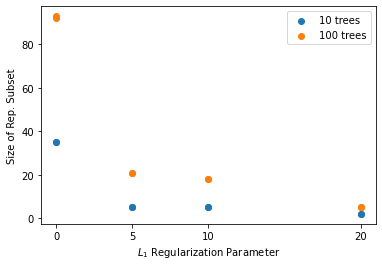

In [60]:
# Figure TODO

plt.scatter(df10.regularization.values, df10.subset_size.values)
plt.scatter(df100.regularization.values, df100.subset_size.values)
plt.legend(["10 trees", "100 trees"])
plt.ylabel("Size of Rep. Subset")
plt.xlabel("$L_1$ Regularization Parameter")
plt.xticks([0, 5, 10, 20])
plt.savefig("l1.png", bbox_inches='tight', dpi=600)

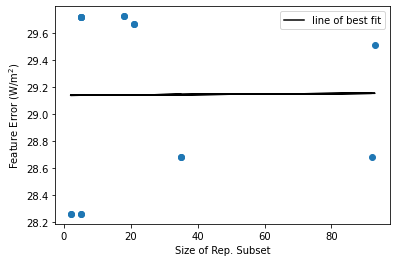

In [67]:
# figure TODO
x, y = df.subset_size.values, df.feature_errors.values
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, c = 'k')

plt.scatter(df.subset_size.values, df.feature_errors.values)
plt.legend(["line of best fit"])
plt.xlabel("Size of Rep. Subset")
plt.ylabel("Feature Error (W/m$^2$)")
plt.savefig("line.png", bbox_inches='tight', dpi=600)

In [68]:
m

0.00016527800930905934

In [45]:
# create prediction value for 10 trees df

data = np.array([df10[df10['tree_depth'] == 6].prediction_errors.values, 
df10[df10['tree_depth'] == 10].prediction_errors.values])
data

array([[ 8.55788898, 14.53980064, 15.96583939, 19.44428253],
       [ 8.55160904, 14.53980064, 15.96583939, 19.44428253]])

In [46]:
# compute mean error for paper

print(np.mean(data))

14.626167893409729


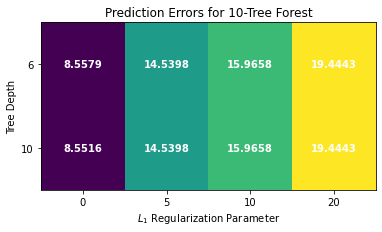

In [47]:
# generate figure TODO

plt.imshow(data, cmap = 'viridis')
plt.xticks(range(len(L1_reg)), L1_reg)
plt.yticks(range(len(tree_depth)), tree_depth)

# Loop over data dimensions and create text annotations.
for i in range(len(tree_depth)):
    for j in range(len(L1_reg)):
        text = plt.text(j, i, data[i, j].round(4),
                       ha="center", va="center", color="w", fontweight = "bold")
plt.xlabel("$L_1$ Regularization Parameter")
plt.ylabel("Tree Depth")
plt.title("Prediction Errors for 10-Tree Forest")
plt.savefig("predict10.png", bbox_inches='tight', dpi=600)

In [48]:
# create feature importance for 10 trees df

data = np.array([df10[df10['tree_depth'] == 6].feature_errors.values, 
df10[df10['tree_depth'] == 10].feature_errors.values])

In [49]:
# compute mean error for paper

print(np.mean(data))

29.097386758635043


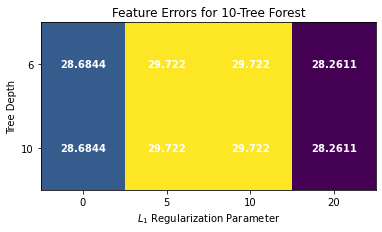

In [50]:
# generate figure TODO

plt.imshow(data, cmap = 'viridis')
plt.xticks(range(len(L1_reg)), L1_reg)
plt.yticks(range(len(tree_depth)), tree_depth)

# Loop over data dimensions and create text annotations.
for i in range(len(tree_depth)):
    for j in range(len(L1_reg)):
        text = plt.text(j, i, data[i, j].round(4),
                       ha="center", va="center", color="w", fontweight = "bold")
plt.xlabel("$L_1$ Regularization Parameter")
plt.ylabel("Tree Depth")
plt.title("Feature Errors for 10-Tree Forest")
plt.savefig("feature10.png", bbox_inches='tight', dpi=600)

In [51]:
# create prediction errors for 100 trees df

data = np.array([df100[df100['tree_depth'] == 6].prediction_errors.values, 
df100[df100['tree_depth'] == 10].prediction_errors.values])

In [52]:
# compute mean error for paper

print(np.mean(data))

13.600260138511658


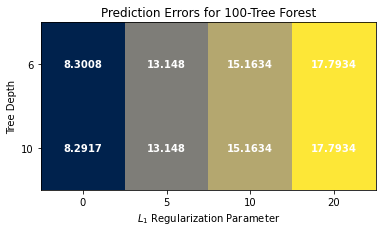

In [53]:
# generate figure TODO

plt.imshow(data, cmap = 'cividis')
plt.xticks(range(len(L1_reg)), L1_reg)
plt.yticks(range(len(tree_depth)), tree_depth)

# Loop over data dimensions and create text annotations.
for i in range(len(tree_depth)):
    for j in range(len(L1_reg)):
        text = plt.text(j, i, data[i, j].round(4),
                       ha="center", va="center", color="w", fontweight = "bold")
plt.xlabel("$L_1$ Regularization Parameter")
plt.ylabel("Tree Depth")
plt.title("Prediction Errors for 100-Tree Forest")
plt.savefig("predict100.png", bbox_inches='tight', dpi=600)

In [54]:
# create feature importance for 100 trees df

data = np.array([df100[df100['tree_depth'] == 6].feature_errors.values, 
df100[df100['tree_depth'] == 10].feature_errors.values])

In [55]:
# compute mean error for paper

print(np.mean(data))

29.187911159713032


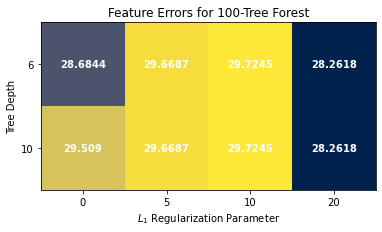

In [56]:
# generate figure TODO

plt.imshow(data, cmap = 'cividis')
plt.xticks(range(len(L1_reg)), L1_reg)
plt.yticks(range(len(tree_depth)), tree_depth)

# Loop over data dimensions and create text annotations.
for i in range(len(tree_depth)):
    for j in range(len(L1_reg)):
        text = plt.text(j, i, data[i, j].round(4),
                       ha="center", va="center", color="w", fontweight = "bold")
plt.xlabel("$L_1$ Regularization Parameter")
plt.ylabel("Tree Depth")
plt.title("Feature Errors for 100-Tree Forest")
plt.savefig("feature100.png", bbox_inches='tight', dpi=600)